In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from cmcrameri import cm
from matplotlib import colors
import matplotlib.patches as patches

In [3]:
EXPERIMENT_DIR = '/data2/experiments/P3856'
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'
EXPERIMENT_NAME = 'P3856'

In [4]:
cuboids_df = pd.read_pickle('{}/precursor-cuboids-3did/exp-{}-run-{}-mz-600-800-precursor-cuboids.pkl'.format(EXPERIMENT_DIR, EXPERIMENT_NAME, RUN_NAME))
cuboids_df.sort_values(by=['anchor_point_intensity'], ascending=False, inplace=True)


In [5]:
len(cuboids_df)

7121

In [42]:
cuboid_s = cuboids_df.iloc[3]
cuboid_s

mz_lower                              787.186461
mz_upper                              789.925700
scan_lower                            379.000000
scan_upper                            429.000000
rt_lower                             2158.288659
rt_upper                             2168.288659
anchor_point_intensity               6904.000000
anchor_point_mz                       787.406482
anchor_point_scan                     403.000000
anchor_point_retention_time_secs     2163.288659
anchor_point_frame_id               19457.000000
number_of_isotope_clusters              2.000000
number_of_isotopes                      6.000000
precursor_cuboid_id                  6054.000000
Name: 6054, dtype: float64

In [43]:
mz_lower = cuboid_s.mz_lower
mz_upper = cuboid_s.mz_upper
scan_lower = cuboid_s.scan_lower
scan_upper = cuboid_s.scan_upper
rt_lower = cuboid_s.rt_lower
rt_upper = cuboid_s.rt_upper

In [44]:
ap_intensity = int(cuboid_s.anchor_point_intensity)
ap_mz = cuboid_s.anchor_point_mz
ap_scan = int(cuboid_s.anchor_point_scan)
ap_rt = cuboid_s.anchor_point_retention_time_secs
ap_frame_id = int(cuboid_s.anchor_point_frame_id)

In [45]:
SCAN_OFFSET_LOWER = 100
SCAN_OFFSET_UPPER = 100
MZ_OFFSET_LOWER = 0.5
MZ_OFFSET_UPPER = 0.5
RT_OFFSET_LOWER = 5.0
RT_OFFSET_UPPER = 5.0

In [46]:
wide_mz_lower = mz_lower - MZ_OFFSET_LOWER
wide_mz_upper = mz_upper + MZ_OFFSET_UPPER
wide_scan_lower = scan_lower - SCAN_OFFSET_LOWER
wide_scan_upper = scan_upper + SCAN_OFFSET_UPPER
wide_rt_lower = rt_lower - RT_OFFSET_LOWER
wide_rt_upper = rt_upper + RT_OFFSET_UPPER

In [47]:
# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8

In [48]:
converted_db_name = '{}/converted-databases/exp-{}-run-{}-converted.sqlite'.format(EXPERIMENT_DIR, EXPERIMENT_NAME, RUN_NAME)

In [49]:
db_conn = sqlite3.connect(converted_db_name)
wide_cuboid_points_df = pd.read_sql_query("select * from frames where frame_type == {} and mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {}".format(FRAME_TYPE_MS1, wide_mz_lower, wide_mz_upper, wide_scan_lower, wide_scan_upper, wide_rt_lower, wide_rt_upper), db_conn)
db_conn.close()

In [50]:
cuboid_points_df = wide_cuboid_points_df[(wide_cuboid_points_df.mz >= mz_lower) & (wide_cuboid_points_df.mz <= mz_upper) & (wide_cuboid_points_df.scan >= scan_lower) & (wide_cuboid_points_df.scan <= scan_upper) & (wide_cuboid_points_df.retention_time_secs >= rt_lower) & (wide_cuboid_points_df.retention_time_secs <= rt_upper)]


In [51]:
wide_cuboid_points_ap_frame_df = wide_cuboid_points_df[(wide_cuboid_points_df.frame_id == ap_frame_id)]

In [52]:
wide_cuboid_points_df.sort_values(by=['intensity'], ascending=True, inplace=True)

In [53]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=100, vmax=2000, clip=True)


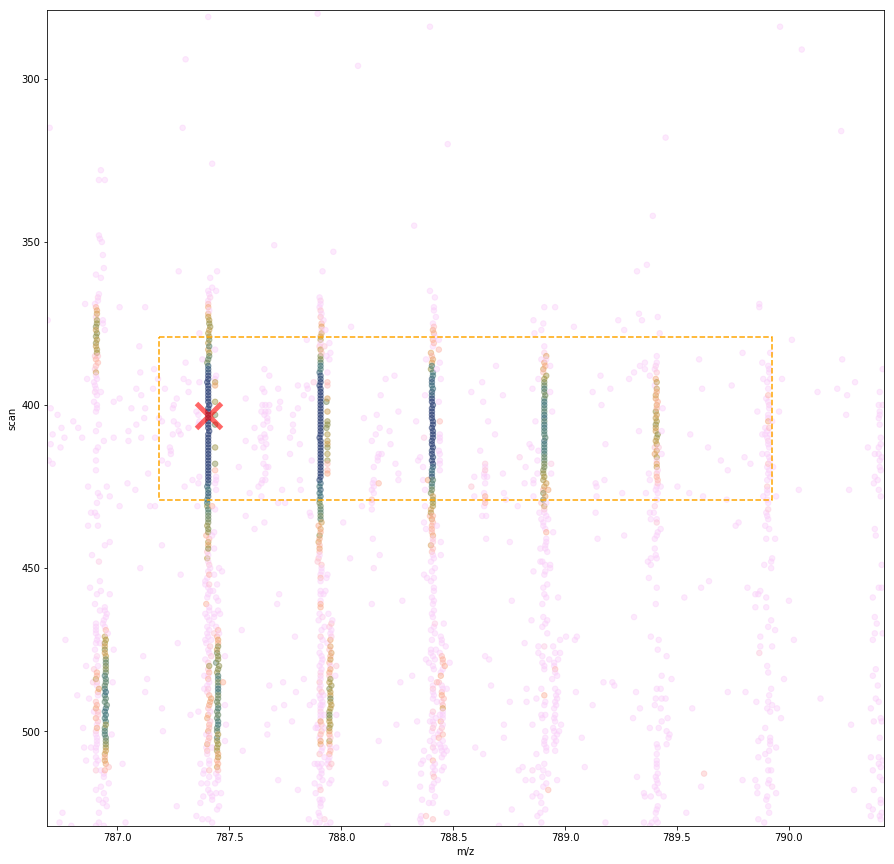

In [54]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(wide_cuboid_points_ap_frame_df.mz, wide_cuboid_points_ap_frame_df.scan, c=wide_cuboid_points_ap_frame_df.intensity, cmap=colour_map, norm=norm, alpha=0.4, s=30, linewidths=None, edgecolors=None)
plt.plot(ap_mz, ap_scan, marker='x', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=5, ms=25, alpha=0.6, label='anchor point')

# draw the cuboid extent
top_left = (mz_lower,scan_lower)
width = mz_upper - mz_lower
height = scan_upper - scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.5,linestyle='--',edgecolor='orange',facecolor='none')
ax1.add_patch(cuboid_rect)

plt.xlabel("m/z")
plt.ylabel("scan")

plt.xlim([wide_mz_lower, wide_mz_upper])
plt.ylim([wide_scan_lower, wide_scan_upper])

plt.gca().invert_yaxis()
plt.show()

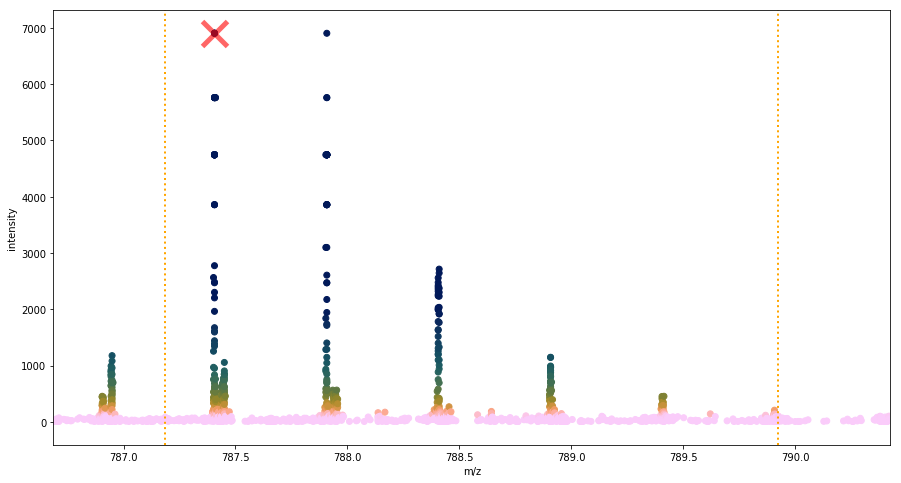

In [55]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(wide_cuboid_points_ap_frame_df.mz, wide_cuboid_points_ap_frame_df.intensity, c=wide_cuboid_points_ap_frame_df.intensity, cmap=colour_map, norm=norm)
plt.axvline(x=mz_lower, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=mz_upper, linestyle=':', color='orange', linewidth=2)
plt.plot(ap_mz, ap_intensity, marker='x', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=5, ms=25, label='anchor point', alpha=0.6)

plt.xlim([wide_mz_lower, wide_mz_upper])

plt.xlabel("m/z")
plt.ylabel("intensity")
plt.show()

In [56]:
wide_scan_df = wide_cuboid_points_df.groupby(['scan'], as_index=False).intensity.sum()
wide_scan_df.sort_values(by=['scan'], ascending=True, inplace=True)

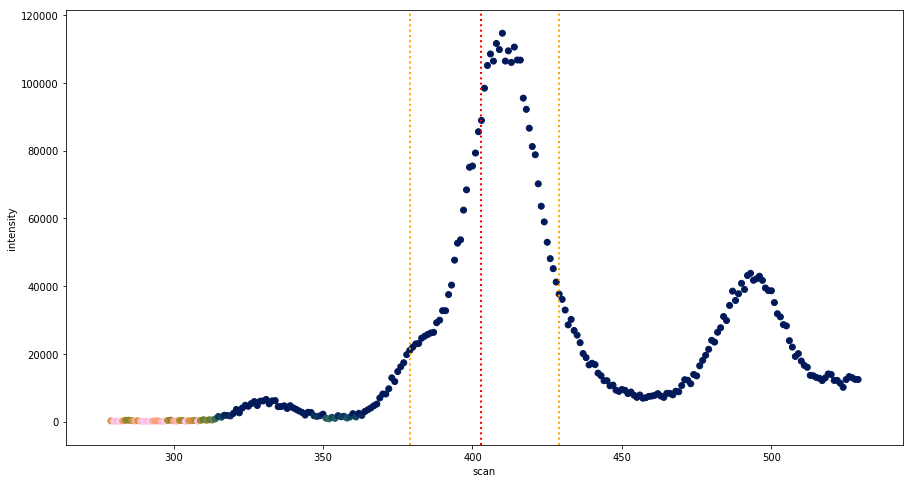

In [57]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(wide_scan_df.scan, wide_scan_df.intensity, c=wide_scan_df.intensity, cmap=colour_map, norm=norm)
plt.axvline(x=scan_lower, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=scan_upper, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=ap_scan, linestyle=':', color='red', linewidth=2)

plt.xlabel("scan")
plt.ylabel("intensity")
plt.show()

In [58]:
wide_rt_df = wide_cuboid_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
wide_rt_df.sort_values(by=['frame_id','retention_time_secs'], ascending=True, inplace=True)

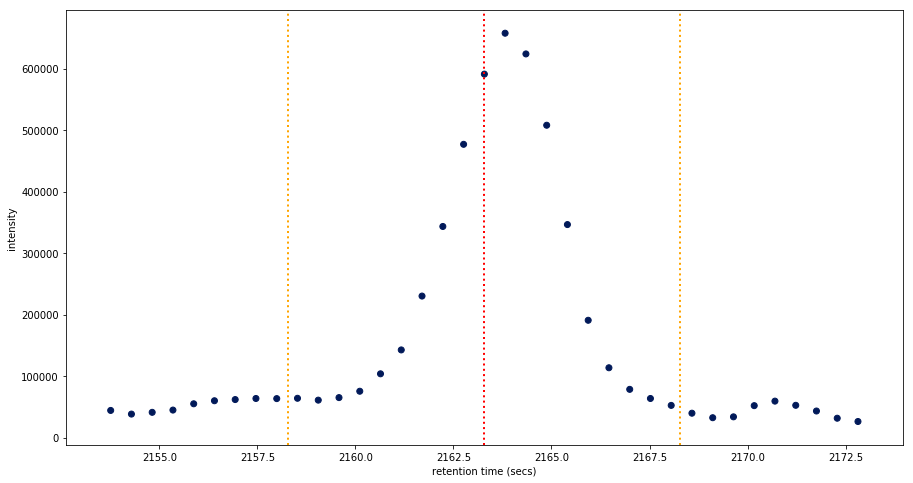

In [59]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(wide_rt_df.retention_time_secs, wide_rt_df.intensity, c=wide_rt_df.intensity, cmap=colour_map, norm=norm)
plt.axvline(x=rt_lower, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=rt_upper, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=ap_rt, linestyle=':', color='red', linewidth=2)

plt.xlabel("retention time (secs)")
plt.ylabel("intensity")
plt.show()